# SVO Analysis
* Last Update: 20-Feb-2023
* Expansion: [Eightfold Abyss: Azvaldt (v4.0.20 update: Mini-Expansion)](https://shadowverse.com/news/?announce_id=2570)

## Introduction

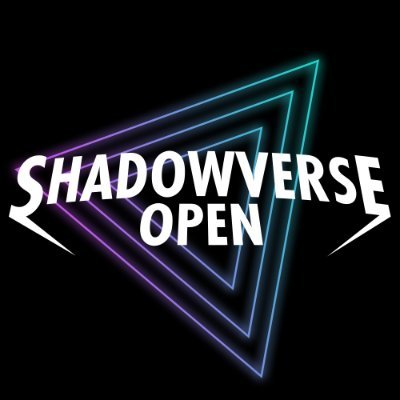

**[Shadowverse Open](https://svo.gg/)** is a popular tournament series that is organised in the SEAO and WEST region, under the **3Deck1Ban format in Rotation**. A similar approach to what was outline in `JCGAnalysis.ipynb` will be used to find out the popularity of lineups and any interesting insights that we can gather from this format. As such, some of the structures/code will be similar with some tweaks.

**Please refer to `JCGAnalysis.ipynb` for a more detailed explanation of the steps taken.**

In [1]:
## Import the libraries
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import xlsxwriter

## Importing the files and data cleaning

Unlike JCG, the decklists cannot be scraped from websites such as battlefy. **An input file shall be used, with the following headers:**

| **_Column_** 	| **_Definition_**                                                                                     	|
|--------------	|------------------------------------------------------------------------------------------------------	|
| **Name**  	| Name of registered player                            	|
| **Player ID**	| 9-digit Shadowverse ID of player. (no white spaces)  	|
| **Deck 1** 	| shadowverse-portal link of Deck 1  	|
| **Deck 2** 	| shadowverse-portal link of Deck 2  	|
| **Deck 3**   	| shadowverse-portal link of Deck 3  	|

The official decklists are provided by the [SVO team](https://twitter.com/SVO_Esports), usually via a first announcement on the [SVO Discord Server](https://discord.gg/svoesports) and subsequently on the official [SVO website](https://svo.gg/).

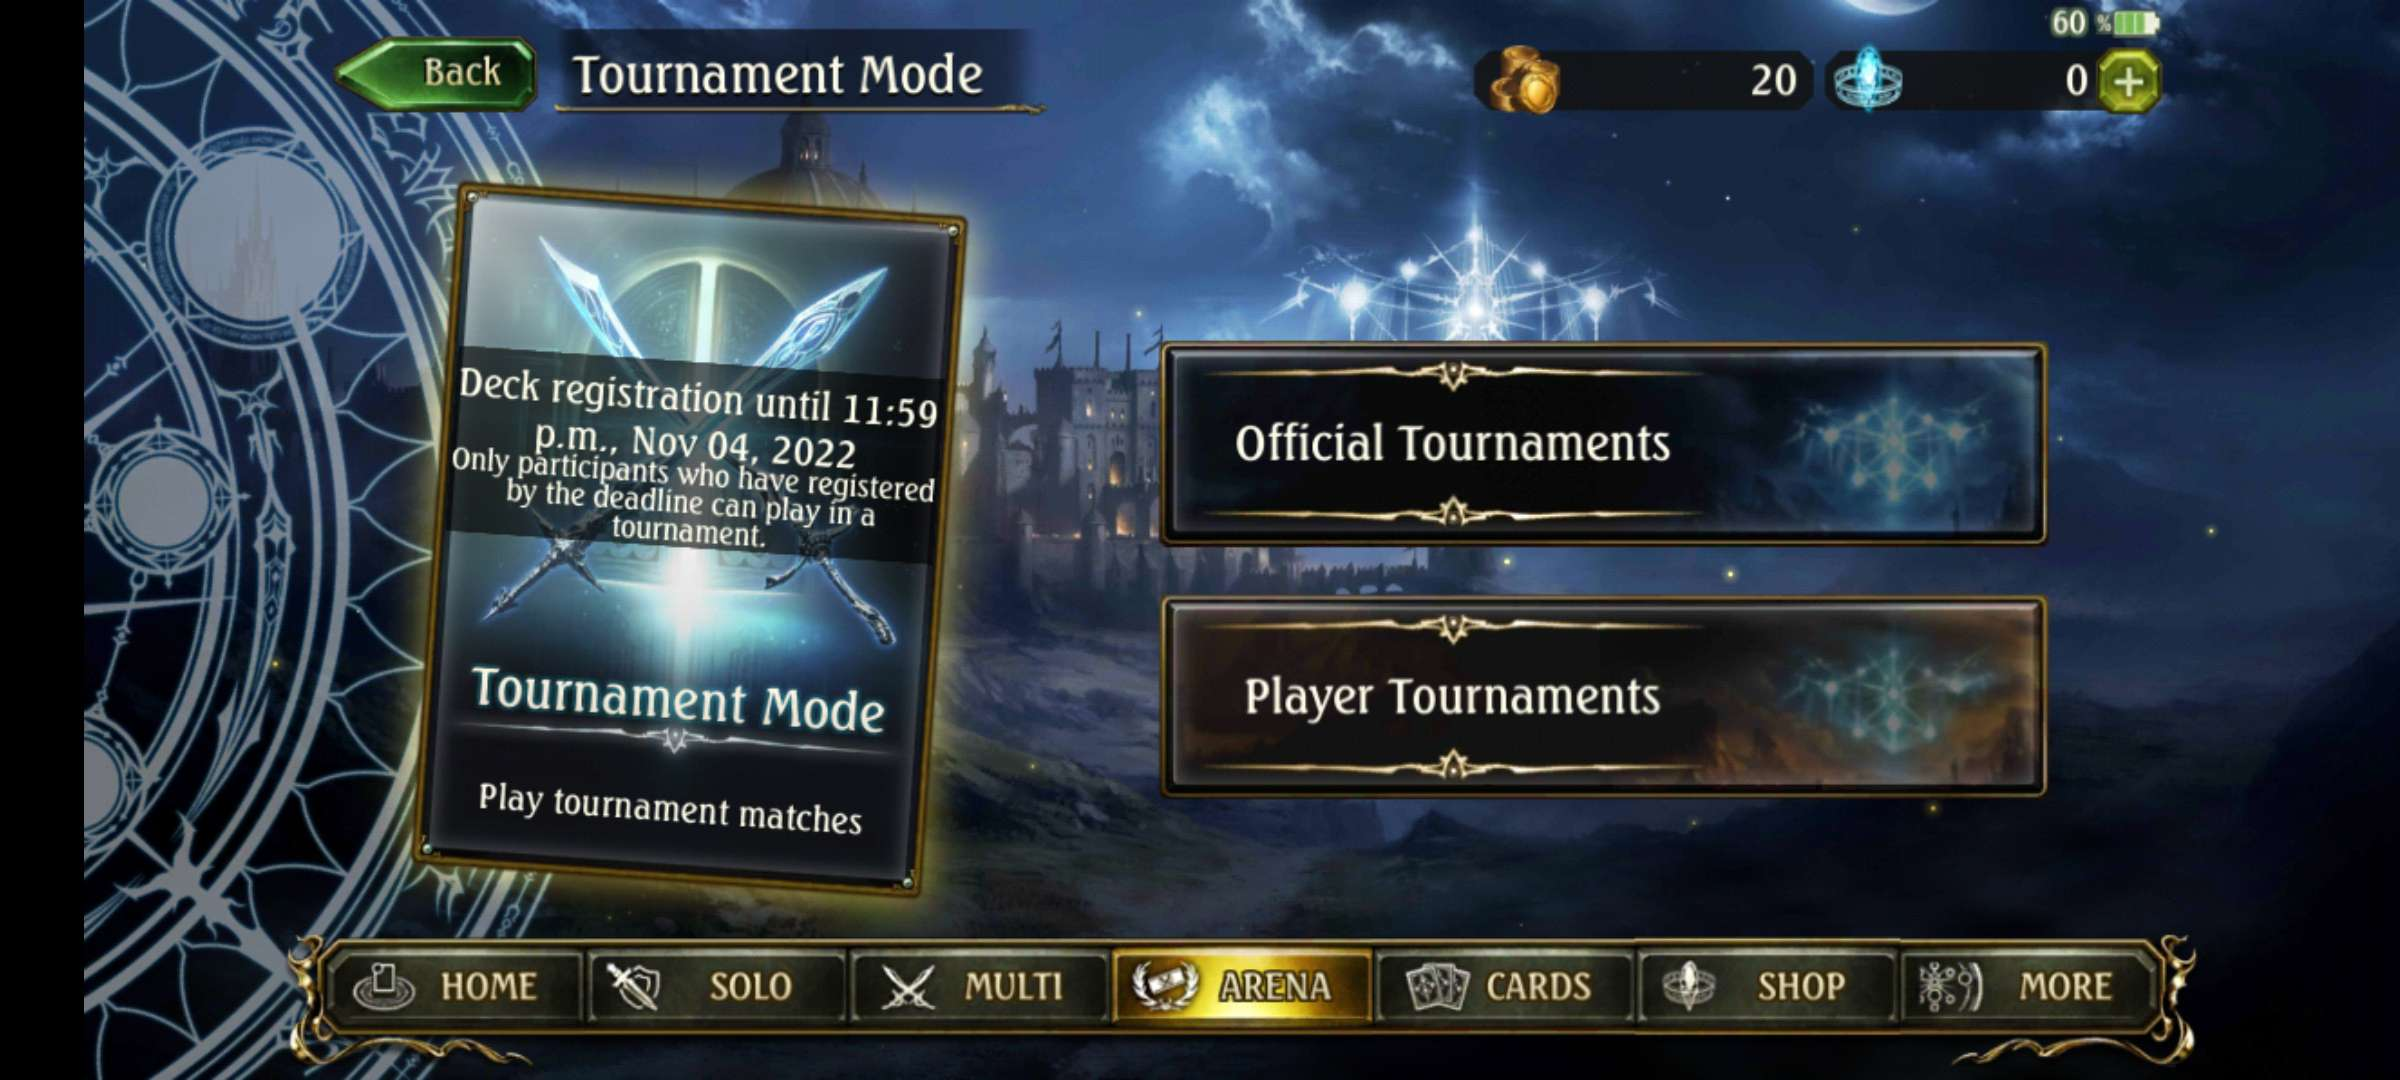

Decklists are submitted by players in-client through Arena > Tournament Mode > Official Tournaments. In terms of data cleaning, the only issue encountered thus far are players who have failed to register their decks on time. 

An example is shown below between MS fuyu and MightyRoos:

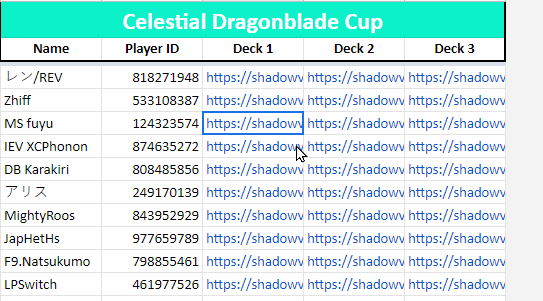

Non-registered decks when pulled from the client returns an invalid URL with the Forestcraft class without any accompanying card hashes. As such, players who did not successfully register three valid decks shall be deemed as non-participants and dropped.

In [2]:
## Specify the directory of input file, and convert it to DataFrame
rawdf_1 = pd.read_csv('input/SVO_SEAO_Nov2022.csv')

## Import hashfiles of card
cardhash_df = pd.read_excel("SVCardInfo.xlsx", sheet_name="FileData")
cardhash_dict = cardhash_df.set_index("hash")["base_card_name"].to_dict()

## Import function
from DeckClassify import DeckSearch

In [3]:
## Data Cleaning - Invalid decks pulled from client
rawdf_1 = rawdf_1.loc[(rawdf_1['Deck 1'].str.len() >= 287) | (rawdf_1['Deck 2'].str.len() >= 287) | (rawdf_1['Deck 3'].str.len() >= 287)].copy().reset_index(drop = True)

In [4]:
## First sort the classes (use sorted which return a value, do not use sort). Then create columns for decks.
rawdf_1['ListOfDecks'] = rawdf_1.apply(lambda x: sorted([x['Deck 1'], x['Deck 2'], x['Deck 3']]), axis = 1)
for n in range(3):
    rawdf_1[f"Deck{n+1}_URL"] = rawdf_1["ListOfDecks"].apply(lambda x: x[n])

## Keep only relevant columns for subsequent use.
rawdf_2 = rawdf_1[['Name', 'Player ID', 'Deck1_URL', 'Deck2_URL', 'Deck3_URL']].copy()

## Deck Classification & Summarization

In [5]:
## Prepare wide format
## 1. Replace card hash with card names
for n in range(1, 4):
    rawdf_2[f"Deck{n}"] = rawdf_2[f"Deck{n}_URL"].replace(cardhash_dict, regex=True)
## 2. Pass function to classify decks    
for n in range(1, 4):
    rawdf_2[f"Deck{n}"] = rawdf_2[f"Deck{n}"].apply(lambda d: DeckSearch(d))
## 3. Create a new column containing the lineups. To convert to tuple for immutability for sorting later.
rawdf_2["Lineup"] = rawdf_2.apply(lambda x: tuple([x["Deck1"], x["Deck2"], x["Deck3"]]), axis=1)
rawdf_2["C_Lineup"] = rawdf_2.apply(lambda x: tuple([x["Deck1"].split(" ")[-1].title() + "craft", x["Deck2"].split(" ")[-1].title() + "craft", x["Deck3"].split(" ")[-1].title() + "craft"]), axis=1)
## 4. Sort & Prepare wide format (Wide)
rawdf_2 = rawdf_2[['Name', 'Player ID', 'Deck1_URL', 'Deck2_URL', 'Deck3_URL', 'Deck1', 'Deck2', 'Deck3', 'Lineup', 'C_Lineup']]
rawdf_2 = rawdf_2.sort_values(['C_Lineup', 'Lineup', 'Name'], ascending=[True, True, True]).reset_index(drop = True)

In [6]:
## Prepare columnar format (Tall)
## 1. Stack vertically using concat, prepare two copies with renamed columns. Ignore index on appending.
svo_dftall = pd.concat([rawdf_2[["Player ID", "Name", "Deck1_URL", "Deck1"]].copy().rename(columns = {"Deck1_URL":"Deck_URL", "Deck1":"Deck"}), 
                        rawdf_2[["Player ID", "Name", "Deck2_URL", "Deck2"]].copy().rename(columns = {"Deck2_URL":"Deck_URL", "Deck2":"Deck"}),
                        rawdf_2[["Player ID", "Name", "Deck3_URL", "Deck3"]].copy().rename(columns = {"Deck3_URL":"Deck_URL", "Deck3":"Deck"})], ignore_index=True)
## 2. Create a column for classes using string slicing.
svo_dftall["Class"] = svo_dftall["Deck"].apply(lambda x: x.split(" ")[-1].title() + "craft")
## 3. Sort
svo_dftall = svo_dftall.sort_values(["Player ID", "Deck_URL", "Deck"], ascending=[True, True, True]).reset_index(drop = True)

In [7]:
## Create Summary DataFrame
## Deck Summary
deck_summary_df = svo_dftall[["Deck", "Class"]].value_counts().reset_index(name='Count')
deck_summary_df["%ofPlayers"] = deck_summary_df["Count"]/(deck_summary_df["Count"].sum()/3)
## Class Summary
class_summary_df = svo_dftall[["Class"]].value_counts().reset_index(name='Count')
class_summary_df["%ofPlayers"] = class_summary_df["Count"]/(class_summary_df["Count"].sum()/3)
## Lineup Summary
lineup_summary_df = rawdf_2[["Lineup"]].value_counts().reset_index(name='Count')
lineup_summary_df["%ofPlayers"] = lineup_summary_df["Count"]/(lineup_summary_df["Count"].sum())
## C_Lineup Summary
clineup_summary_df = rawdf_2[["C_Lineup"]].value_counts().reset_index(name='Count')
clineup_summary_df["%ofPlayers"] = clineup_summary_df["Count"]/(clineup_summary_df["Count"].sum())

## Deck Breakdown

In [8]:
## Deck Breakdown. Loop through columnar format for each decks in each classes, then store all DataFrames in a dictionary.
deck_breakdown_dict = {}
for classes in svo_dftall["Class"].unique():
    deck_breakdown_dict[f"{classes}"] = {}
    for deck in sorted(svo_dftall.loc[svo_dftall["Class"] == classes]["Deck"].unique()):
        # 1. Create a view of all players with the same deck archetype.
        player_df = svo_dftall.loc[svo_dftall["Deck"] == deck].copy().sort_values(by=["Name"])
        # 2. For each player, convert Deck_URL to a list of cards in the deck. 
        player_df["Deck_URL"] = player_df["Deck_URL"].apply(lambda x: x.split("deck/")[-1].split("?lang")[0][4:])
        player_df["Cards"] = player_df["Deck_URL"].apply(lambda x: x.split("."))
        player_df["Cards"] = player_df["Cards"].apply(lambda x: [each.replace(each, cardhash_dict[each]) for each in x])
        # 3. Convert list of cards into a DataFrame. Aggregate the Count of each cards with value_counts. Set index header as deck archetype name (which is card name too). Player forms the columns.
        player_df["Cards"] = player_df.apply(lambda x: pd.DataFrame(x["Cards"], columns = [f"{deck}"]).value_counts().to_frame(name = x["Name"]), axis=1)
        # 4. Create a merged DataFrame, displaying the granular breakdown of all players and their ratio of cards.
        player_list = player_df["Cards"].to_list()
        mergeddf = pd.concat(player_list, axis=1)
        # 5. Create a separate DataFrame storing all the descriptive stats.
        mergeddf2 = pd.DataFrame()
        mergeddf2["Count"] = mergeddf.apply(lambda x: x.count(), axis = 1)
        mergeddf2["Mean"] = mergeddf.apply(lambda x: x.mean(), axis = 1)
        mergeddf2["Median"] = mergeddf.apply(lambda x: x.median(), axis = 1)
        mergeddf2["SD"] = mergeddf.apply(lambda x: x.std(), axis = 1)
        # 6. Merge descriptive stats DataFrame to the front, with granular DataFrame. Then append to dictionary container
        mergeddf3 = pd.concat([mergeddf2, mergeddf], axis=1).sort_values(by=['Count', f"{deck}"], ascending=[False, True])
        deck_breakdown_dict[f"{classes}"][f"{deck}"] = (mergeddf3)

## Exporting the results

In [9]:
def DeckBreakdownToExcel(deck_breakdown_dict, jwriter, jworkbook):
    # 1. Loop through fixed classes_order, create a new sheet for every deck archetype.
    classes_order = ["Forestcraft", "Swordcraft", "Runecraft", "Dragoncraft", "Shadowcraft", "Bloodcraft", "Havencraft", "Portalcraft"]
    for classes in classes_order:
        for deck, stats_df in deck_breakdown_dict[classes].items():
            stats_df.to_excel(jwriter, sheet_name=f"{deck}", index=True)
            # 2. Set active sheet to newly added sheet.
            jworksheet = jwriter.sheets[deck]
            # 3. Beautify active sheet
            decimal_fmt = jworkbook.add_format({'num_format': '0.00'})
            jworksheet.set_column('C:E', 10, decimal_fmt) ## set descriptive stats to decimal format.
            jworksheet.set_column('A:A', 30) ## set the width = 30 and bold for column A:A
            jworksheet.freeze_panes(0, 5) ## Freeze left columns, Cards and descriptive stats.
            # xlsxwriter requires format to be passed with .write(), which requires an input cell value too. Iterate through DataFrame.column
            descstats_header_format = jworkbook.add_format({'bold': True, 'text_wrap': False, 'align': 'center', 'valign': 'vcenter', 'font_size': 15, 'rotation':0})
            player_header_format = jworkbook.add_format({'bold': True, 'text_wrap': True, 'align': 'center', 'valign': 'vcenter', 'font_size': 12, 'rotation':90})
            for col_num, value in enumerate(stats_df.columns.values): ## Write the column headers with the defined format.
                if col_num+1 < 5:
                    jworksheet.write(0, col_num+1, value, descstats_header_format)
                else:
                    jworksheet.write(0, col_num+1, value, player_header_format)
            deck_header_format = jworkbook.add_format({'bold': True, 'text_wrap': True, 'align': 'center', 'valign': 'vcenter', 'font_size': 20, 'rotation':0, 'border':2})
            jworksheet.write(0, 0, deck, deck_header_format) ## Formatting for deck at cell A1
            # 4. Set tab colors
            tabcolours = {'Forestcraft': 'green', 'Swordcraft': 'yellow', 'Runecraft': 'blue', 'Dragoncraft': 'orange', 'Shadowcraft': 'purple', 'Bloodcraft': 'red', 'Havencraft': 'silver', 'Portalcraft': 'cyan'}
            for craft, colour in tabcolours.items():
                if classes == craft:
                    jworksheet.set_tab_color(colour)

In [10]:
def SVOExcelFormatter(svowriter, svoworkbook, input_filename):
    # 1. Set the color conditional formatting for classes and decks.
    greenFill = svoworkbook.add_format({'bg_color': '#c6ffb3', 'font_color': '#000000'})
    yellowFill = svoworkbook.add_format({'bg_color': '#ffffb3', 'font_color': '#000000'})
    blueFill = svoworkbook.add_format({'bg_color': '#b3d9ff', 'font_color': '#000000'})
    orangeFill = svoworkbook.add_format({'bg_color': '#ffd9b3', 'font_color': '#000000'})
    purpleFill = svoworkbook.add_format({'bg_color': '#ecb3ff', 'font_color': '#000000'})
    redFill = svoworkbook.add_format({'bg_color': '#ffb3b3', 'font_color': '#000000'})
    greyFill = svoworkbook.add_format({'bg_color': '#e6e6e6', 'font_color': '#000000'})
    tealFill = svoworkbook.add_format({'bg_color': '#b3ffff', 'font_color': '#000000'})
    def ConditionFormatter(worksheet, lookuprange):
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Forest', 'format': greenFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Sword', 'format': yellowFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Rune', 'format': blueFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Dragon', 'format': orangeFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Shadow', 'format': purpleFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Blood', 'format': redFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Haven', 'format': greyFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Portal', 'format': tealFill})
        
    # 2. Set active sheet and format accordingly.
    col_widths = {"Name": 20, 
                  "Player ID": 11,
                  "Deck_URL": 11,
                  "Deck": 20,
                  "Lineup": 55,
                  "C_Lineup": 38,
                  "Pos": 4,
                  "Count": 6,
                  "%ofPlayers": 10,
                  "Class": 18}
    
    svoworksheet = svowriter.sheets["Wide"]
    svoworksheet.set_column('A:A', col_widths["Name"]) ## Name
    svoworksheet.set_column('B:B', col_widths["Player ID"]) ## Player ID
    svoworksheet.set_column('C:E', col_widths["Deck_URL"]) ## Deck_URL 
    ConditionFormatter(svoworksheet, 'F1:H999') ## Deck 
    svoworksheet.set_column('F:H', col_widths["Deck"]) ## Deck 
    svoworksheet.set_column('I:I', col_widths["Lineup"]) ## Lineup 
    svoworksheet.set_column('J:J', col_widths["C_Lineup"]) ## C_Lineup
    # svoworksheet.set_column('I:I', col_widths["Pos"]) ## Pos
    
    svoworksheet = svowriter.sheets["Tall"]
    svoworksheet.set_column('A:A', col_widths["Name"]) ## Name
    svoworksheet.set_column('B:B', col_widths["Player ID"]) ## Player ID
    svoworksheet.set_column('C:C', col_widths["Deck_URL"]) ## Deck_URL 
    ConditionFormatter(svoworksheet, 'D1:E999') ## Deck, Class
    svoworksheet.set_column('D:D', col_widths["Deck"]) ## Deck 
    svoworksheet.set_column('E:E', col_widths["Class"]) ## Class 
    svoworksheet.set_column('F:F', col_widths["Pos"]) ## Pos
    
    svoworksheet = svowriter.sheets["Summary"]
    svoworksheet.set_column('A:A', col_widths["Deck"]) ## Deck 
    svoworksheet.set_column('B:B', col_widths["Class"]) ## Class 
    ConditionFormatter(svoworksheet, 'A2:B999') ## Deck, Class
    svoworksheet.set_column('C:C', col_widths["Count"]) ## Count
    svoworksheet.set_column('D:D', col_widths["%ofPlayers"], svoworkbook.add_format({'num_format': '0.00%'})) ## %ofPlayers 
    svoworksheet.set_column('E:E', 1) ## BLANK 
    svoworksheet.set_column('F:F', col_widths["Lineup"]) ## Lineup
    svoworksheet.set_column('G:G', col_widths["Count"]) ## Count
    svoworksheet.set_column('H:H', 10, svoworkbook.add_format({'num_format': '0.00%'})) ## %ofPlayers
    svoworksheet.set_column('I:I', 1) ## BLANK 
    svoworksheet.set_column('J:J', col_widths["C_Lineup"]) ## C_Lineup
    svoworksheet.set_column('K:K', col_widths["Count"]) ## Count
    svoworksheet.set_column('L:L', col_widths["%ofPlayers"], svoworkbook.add_format({'num_format': '0.00%'})) ## %ofPlayers
    merge_fmt = svoworkbook.add_format({'bold': 1, 'border': 1, 'align': 'center','valign': 'vcenter', 'font_size': 20})
    svoworksheet.merge_range('A1:L1', f'{input_filename} Summary - {rawdf_2.shape[0]} Players', merge_fmt)

In [ ]:
## Specify the file name and directory folder Output
input_filename = input('Please type tournament name: ')
export_filename = f"Output/{input_filename.replace(' ', '_')}.xlsx"
svowriter = pd.ExcelWriter(export_filename)
svoworkbook = svowriter.book

## Add DataFrames to Sheets
deck_summary_df.to_excel(svowriter, sheet_name="Summary", index=False, startrow = 1, startcol = 0) ## Deck Archetype
class_summary_df.to_excel(svowriter, sheet_name="Summary", index=False, startrow = deck_summary_df.shape[0] + 3, startcol = 1) ## Class Summary, To be placed below Deck Archetype Table
lineup_summary_df.to_excel(svowriter, sheet_name="Summary", index=False, startrow = 1, startcol = 5) ## Lineup Statistics
clineup_summary_df.to_excel(svowriter, sheet_name="Summary", index=False, startrow = 1, startcol = 9) ## C_Lineup Statistics
rawdf_2.to_excel(svowriter, sheet_name='Wide', index=False) ## Wide
svo_dftall.to_excel(svowriter, sheet_name='Tall', index=False) ## Tall
DeckBreakdownToExcel(deck_breakdown_dict, svowriter, svoworkbook)

## Run the Export functions for fomatting.
SVOExcelFormatter(svowriter, svoworkbook, input_filename)
## Save to Excel file
svowriter.save()
svowriter.close()

## Battlefy Information + Data Massage using Zhiff's table
- Last update: 20-Feb-2023

In [2]:
## Import the data from Zhiff after some data massage
## To manually insert Player ID for matching purposes
# svoInfo = pd.read_excel(r'Input\230211 SVO SEAO.xlsx', sheet_name = 0) ## SEAO Feb
svoInfo = pd.read_csv(r'Input\230218 SVO WEST.csv')


## Trim whitespaces
svoInfo['deck 1'] = svoInfo['deck 1'].apply(lambda x: x.strip())
svoInfo['deck 2'] = svoInfo['deck 2'].apply(lambda x: x.strip())
svoInfo['deck 3'] = svoInfo['deck 3'].apply(lambda x: x.strip())

## From deck 1 to 3, create columns for lineups
## 3. Create a new column containing the lineups. To convert to tuple for immutability for sorting later.
svoInfo["Lineup"] = svoInfo.apply(lambda x: tuple([x["deck 1"], x["deck 2"], x["deck 3"]]), axis=1)
svoInfo["C_Lineup"] = svoInfo.apply(lambda x: tuple([x["deck 1"].split(" ")[-1].title() + "craft", 
                                                     x["deck 2"].split(" ")[-1].title() + "craft", 
                                                     x["deck 3"].split(" ")[-1].title() + "craft"]), axis=1)

In [3]:
## Get json from battlefy url
# targetRound = 'https://dtmwra1jsgyb0.cloudfront.net/stages/63e6f74840afc412840af0a0/matches' ## SEAO Feb
targetRound = 'https://dtmwra1jsgyb0.cloudfront.net/stages/63f0f9f59be6ee2b705dfb46/matches' ## WEST Feb

jsonResponse = requests.get(targetRound).json()
df = pd.json_normalize(jsonResponse)

## Keep relevant rows for df, remove BYES and AFK rounds
df = df[(df['isBye'] == False) & ~(df['isDoubleLoss'] == True)].reset_index(drop = True)

## Create player identifier by SV ID instead of name
def testfunc(testlist):
    svid = ''
    try:
        for x in testlist:
            if x['_id'] == '63ca5e547efebb0f2500ee93':
                svid = x['value'].replace(' ', '').replace('-', '')
    except:
        svid = ''
    return svid

df['top.team.sv_ID'] = df['top.team.customFields'].apply(lambda x: testfunc(x))
df['bottom.team.sv_ID'] = df['bottom.team.customFields'].apply(lambda x: testfunc(x))

## Manual adjustments after investigation
## SEAO FEB
# # 422767615 --> 442767615
# # 850950018 --> drop
# # 461124376 --> drop
# dropinvalids = ['461124376', '850950018']
# df = df[(~df['top.team.sv_ID'].isin(dropinvalids)) & (~df['bottom.team.sv_ID'].isin(dropinvalids))].reset_index(drop = True)
# df.replace('422767615', '442767615', inplace = True)

## WEST FEB
# 33629764 --> 335629764
df.replace('33629764', '335629764', inplace = True)

In [4]:
## Extract list of participants by ID
participantID = pd.concat((df['top.team.sv_ID'], df['bottom.team.sv_ID'])).unique().tolist()
participantID = [int(x) for x in participantID]

## Create a dictionary with SVID-teamID pair from standings
# targetStandings = 'https://dtmwra1jsgyb0.cloudfront.net/stages/63e6f74840afc412840af0a0/rounds/7/standings' ## SEAO Feb
targetStandings = 'https://dtmwra1jsgyb0.cloudfront.net/stages/63f0f9f59be6ee2b705dfb46/rounds/7/standings' ## WEST Feb
jsonResponse2 = requests.get(targetStandings).json()
standings_df = pd.json_normalize(jsonResponse2)
standings_df['sv_ID'] = standings_df['team.customFields'].apply(lambda x: testfunc(x))

# standings_df = standings_df[(~standings_df['sv_ID'].isin(dropinvalids))].reset_index(drop = True) ## Manual Adjustments
# standings_df.replace('422767615', '442767615', inplace = True)  ## Manual Adjustments
standings_df.replace('33629764', '335629764', inplace = True) ## Manual Adjustments

playerTeamID_dict = standings_df.set_index("sv_ID")["teamID"].to_dict()
playerWins_dict = standings_df.set_index("sv_ID")["wins"].to_dict()

## Filter svoInfo by active participants
svoInfo2 = svoInfo[svoInfo['Player ID'].isin([int(x) for x in participantID])].reset_index(drop = True)

## Create a dictionary with key as ID for replace later.
svoInfo2['Player ID'] = svoInfo2['Player ID'].astype(str)
svoInfo2['teamID'] = svoInfo2['Player ID'].replace(playerTeamID_dict, regex=True)
svoInfo2['SwissWins'] = svoInfo2['Player ID'].replace(playerWins_dict, regex=True)
player_lu_dict = svoInfo2.set_index("Player ID")["Lineup"].to_dict()
player_clu_dict = svoInfo2.set_index("Player ID")["C_Lineup"].to_dict()

## Sort
svoInfo2 = svoInfo2.sort_values(['SwissWins', 'C_Lineup', 'Lineup', 'name'], ascending=[False, True, True, True]).reset_index(drop = True)
svoInfo2 = svoInfo2[['name', 'Player ID', 'SwissWins', 'top8', 'deck 1', 'deck 2', 'deck 3',  'Lineup', 'C_Lineup']]

In [5]:
## Recalculate actual participation stats
## Prepare columnar format (Tall)
## 1. Stack vertically using concat, prepare two copies with renamed columns. Ignore index on appending.
svo_dftall = pd.concat([svoInfo2[["Player ID", "name", "deck 1"]].copy().rename(columns = {"deck 1":"Deck"}), 
                        svoInfo2[["Player ID", "name", "deck 2"]].copy().rename(columns = {"deck 2":"Deck"}),
                        svoInfo2[["Player ID", "name", "deck 3"]].copy().rename(columns = {"deck 3":"Deck"})], ignore_index=True)
## 2. Create a column for classes using string slicing.
svo_dftall["Class"] = svo_dftall["Deck"].apply(lambda x: x.split(" ")[-1].title() + "craft")

## Create Summary DataFrame
## Deck Summary
deck_summary_df = svo_dftall[["Deck", "Class"]].value_counts().reset_index(name='Count')
deck_summary_df["%ofPlayers"] = deck_summary_df["Count"]/(deck_summary_df["Count"].sum()/3)
## Class Summary
class_summary_df = svo_dftall[["Class"]].value_counts().reset_index(name='Count')
class_summary_df["%ofPlayers"] = class_summary_df["Count"]/(class_summary_df["Count"].sum()/3)
## Lineup Summary
lineup_summary_df = svoInfo2[["Lineup"]].value_counts().reset_index(name='Count')
lineup_summary_df["%ofPlayers"] = lineup_summary_df["Count"]/(lineup_summary_df["Count"].sum())
## C_Lineup Summary
clineup_summary_df = svoInfo2[["C_Lineup"]].value_counts().reset_index(name='Count')
clineup_summary_df["%ofPlayers"] = clineup_summary_df["Count"]/(clineup_summary_df["Count"].sum())

In [6]:
## Keep relevant columns for df
df2 = df.copy()[['top.team.sv_ID', 'top.winner', 'top.score', 'bottom.team.sv_ID', 'bottom.winner', 'bottom.score']]
df2.rename(columns = {'top.team.sv_ID': 'P1', 'top.winner': 'P1_Win', 'top.score': 'P1_Games', 
                      'bottom.team.sv_ID': 'P2', 'bottom.winner': 'P2_Win', 'bottom.score': 'P2_Games'}, inplace=True)

## Replace SVID with Lineup
bkt_merged_df_a = df2.copy()
bkt_merged_df_a['P1'] = bkt_merged_df_a['P1'].replace(player_lu_dict, regex=True)
bkt_merged_df_a['P2'] = bkt_merged_df_a['P2'].replace(player_lu_dict, regex=True)

# # ## Pick only relevant columns
bkt_merged_df_b = bkt_merged_df_a[['P1', 'P1_Win', 'P1_Games', 'P2', 'P2_Win', 'P2_Games']].sort_values(['P1', 'P2'], ascending = [True, True]).reset_index(drop = True).copy()
# ## Sort across P1 and P2 lineups
bkt_merged_df_b['sortcheck'] = bkt_merged_df_b.apply(lambda x: 0 if sorted([x['P1'], x['P2']]) == ([x['P1'], x['P2']]) else 1, axis = 1)
bkt_merged_df_b[['P1', 'P2', 'P1_Win', 'P2_Win', 'P1_Games', 'P2_Games']] = bkt_merged_df_b[['P2', 'P1', 'P2_Win', 'P1_Win', 'P2_Games', 'P1_Games']].where(bkt_merged_df_b['sortcheck'] == 1, bkt_merged_df_b[['P1', 'P2', 'P1_Win', 'P2_Win', 'P1_Games', 'P2_Games']].values)
bkt_merged_df_b.drop(['sortcheck'], axis = 1, inplace = True)
# ## Aggregate
bkt_merged_df_c = bkt_merged_df_b.groupby(['P1','P2']).sum().copy()
bkt_merged_df_c['Count'] = bkt_merged_df_c['P1_Win'] + bkt_merged_df_c['P2_Win']
bkt_merged_df_c['Spread'] = bkt_merged_df_c.apply(lambda x: abs((x['P1_Win']-x['P2_Win'])/x['Count']) , axis = 1)
bkt_merged_df_c = bkt_merged_df_c.sort_values(['Count', 'Spread'], ascending = [False, False]).reset_index(drop = False)

## Replace nicename with c_Lineup
bkt_merged_df_i = df2.copy()
bkt_merged_df_i['P1'] = bkt_merged_df_i['P1'].replace(player_clu_dict, regex=True)
bkt_merged_df_i['P2'] = bkt_merged_df_i['P2'].replace(player_clu_dict, regex=True)

## Calculate and aggregate
bkt_merged_df_j = bkt_merged_df_i[['P1', 'P1_Win', 'P1_Games', 'P2', 'P2_Win', 'P2_Games']].sort_values(['P1', 'P2'], ascending = [True, True]).reset_index(drop = True).copy()
## Sort across P1 and P2 lineups
bkt_merged_df_j['sortcheck'] = bkt_merged_df_j.apply(lambda x: 0 if sorted([x['P1'], x['P2']]) == ([x['P1'], x['P2']]) else 1, axis = 1)
bkt_merged_df_j[['P1', 'P2', 'P1_Win', 'P2_Win', 'P1_Games', 'P2_Games']] = bkt_merged_df_j[['P2', 'P1', 'P2_Win', 'P1_Win', 'P2_Games', 'P1_Games']].where(bkt_merged_df_j['sortcheck'] == 1, bkt_merged_df_j[['P1', 'P2', 'P1_Win', 'P2_Win', 'P1_Games', 'P2_Games']].values)
bkt_merged_df_j.drop(['sortcheck'], axis = 1, inplace = True)
## Aggregate
bkt_merged_df_k = bkt_merged_df_j.groupby(['P1','P2']).sum().copy()
bkt_merged_df_k['Count'] = bkt_merged_df_k['P1_Win'] + bkt_merged_df_k['P2_Win']
bkt_merged_df_k['Spread'] = bkt_merged_df_k.apply(lambda x: abs((x['P1_Win']-x['P2_Win'])/x['Count']) , axis = 1)
bkt_merged_df_k = bkt_merged_df_k.sort_values(['Count', 'Spread'], ascending = [False, False]).reset_index(drop = False)

In [7]:
def EdittedExcelFormatter(jwriter, jworkbook):
    # 1. Set the color conditional formatting for classes and decks.
    greenFill = jworkbook.add_format({'bg_color': '#c6ffb3', 'font_color': '#000000'})
    yellowFill = jworkbook.add_format({'bg_color': '#ffffb3', 'font_color': '#000000'})
    blueFill = jworkbook.add_format({'bg_color': '#b3d9ff', 'font_color': '#000000'})
    orangeFill = jworkbook.add_format({'bg_color': '#ffd9b3', 'font_color': '#000000'})
    purpleFill = jworkbook.add_format({'bg_color': '#ecb3ff', 'font_color': '#000000'})
    redFill = jworkbook.add_format({'bg_color': '#ffb3b3', 'font_color': '#000000'})
    greyFill = jworkbook.add_format({'bg_color': '#e6e6e6', 'font_color': '#000000'})
    tealFill = jworkbook.add_format({'bg_color': '#b3ffff', 'font_color': '#000000'})
    def ConditionFormatter(worksheet, lookuprange):
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Forest', 'format': greenFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Sword', 'format': yellowFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Rune', 'format': blueFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Dragon', 'format': orangeFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Shadow', 'format': purpleFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Blood', 'format': redFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Haven', 'format': greyFill})
        worksheet.conditional_format(lookuprange, {'type': 'text', 'criteria': 'containing', 'value': 'Portal', 'format': tealFill})
        
    # 2. Set active sheet and format accordingly.
    col_widths = {"Player": 20, 
                  "PlayerProfile": 11,
                  "Deck_URL": 11,
                  "Deck": 20,
                  "Lineup": 35,
                  "C_Lineup": 30,
                  "Pos": 4,
                  "Count": 6,
                  "%ofPlayers": 10,
                  "Class": 18}
    
    jworksheet = jwriter.sheets["Wide"]
    jworksheet.set_column('A:A', col_widths["Player"]) ## name
    jworksheet.set_column('B:B', col_widths["PlayerProfile"]) ## Player ID
    # jworksheet.set_column('C:D', col_widths["Deck_URL"]) ## Deck_URL 
    jworksheet.set_column('C:C', 9) ## SwissWins
    jworksheet.set_column('D:D', col_widths["Pos"]) ## top8
    ConditionFormatter(jworksheet, 'E1:G999') ## Deck 
    jworksheet.set_column('E:G', col_widths["Deck"]) ## Deck 
    jworksheet.set_column('H:H', 60) ## Lineup 
    jworksheet.set_column('I:I', 36) ## C_Lineup
    # jworksheet.set_column('I:I', col_widths["Pos"]) ## Pos
    
    # jworksheet = jwriter.sheets["Tall"]
    # jworksheet.set_column('A:A', col_widths["PlayerProfile"]) ## PlayerProfile
    # jworksheet.set_column('B:B', col_widths["Player"]) ## Player
    # jworksheet.set_column('C:C', col_widths["Deck_URL"]) ## Deck_URL 
    # ConditionFormatter(jworksheet, 'D1:E999') ## Deck, Class
    # jworksheet.set_column('D:D', col_widths["Deck"]) ## Deck 
    # jworksheet.set_column('E:E', col_widths["Class"]) ## Class 
    # jworksheet.set_column('F:F', col_widths["Pos"]) ## Pos
    
    jworksheet = jwriter.sheets["Summary"]
    jworksheet.set_column('A:A', col_widths["Deck"]) ## Deck 
    jworksheet.set_column('B:B', col_widths["Class"]) ## Class 
    ConditionFormatter(jworksheet, 'A2:B999') ## Deck, Class
    jworksheet.set_column('C:C', col_widths["Count"]) ## Count
    jworksheet.set_column('D:D', col_widths["%ofPlayers"], jworkbook.add_format({'num_format': '0.00%'})) ## %ofPlayers 
    jworksheet.set_column('E:E', 1) ## BLANK 
    jworksheet.set_column('F:F', 60) ## Lineup
    jworksheet.set_column('G:G', col_widths["Count"]) ## Count
    jworksheet.set_column('H:H', 10, jworkbook.add_format({'num_format': '0.00%'})) ## %ofPlayers
    jworksheet.set_column('I:I', 1) ## BLANK 
    jworksheet.set_column('J:J', 36) ## C_Lineup
    jworksheet.set_column('K:K', col_widths["Count"]) ## Count
    jworksheet.set_column('L:L', col_widths["%ofPlayers"], jworkbook.add_format({'num_format': '0.00%'})) ## %ofPlayers
    merge_fmt = jworkbook.add_format({'bold': 1, 'border': 1, 'align': 'center','valign': 'vcenter', 'font_size': 20})
    # jworksheet.merge_range('A1:L1', f'{jcg_name.split(" ロ")[0]} Summary', merge_fmt)
    
    jworksheet = jwriter.sheets["Matchup"]
    jworksheet.merge_range('A1:H1', 'Class Matchup', merge_fmt)
    jworksheet.merge_range('J1:Q1', 'Deck Matchup', merge_fmt)
    jworksheet.set_column('A:A', 36) ## C_Lineup
    jworksheet.set_column('B:B', 36) ## C_Lineup
    jworksheet.set_column('J:J', 60) ## Lineup
    jworksheet.set_column('K:K', 60) ## Lineup
    jworksheet.set_column('H:H', col_widths["%ofPlayers"], jworkbook.add_format({'num_format': '0.00%'})) ## %
    jworksheet.set_column('Q:Q', col_widths["%ofPlayers"], jworkbook.add_format({'num_format': '0.00%'})) ## %

In [8]:
## Specify the file name and directory folder Output
# filename = f"SVO SEAO Feb 2023 Summary"
filename = f"SVO WEST Feb 2023 Summary"
export_filename = f"Output/{filename}.xlsx"
jwriter = pd.ExcelWriter(export_filename)
jworkbook = jwriter.book

## Add DataFrames to Sheets
deck_summary_df.to_excel(jwriter, sheet_name="Summary", index=False, startrow = 0, startcol = 0) ## Deck Archetype
class_summary_df.to_excel(jwriter, sheet_name="Summary", index=False, startrow = deck_summary_df.shape[0] + 3, startcol = 1) ## Class Summary, To be placed below Deck Archetype Table
lineup_summary_df.to_excel(jwriter, sheet_name="Summary", index=False, startrow = 0, startcol = 5) ## Lineup Statistics
clineup_summary_df.to_excel(jwriter, sheet_name="Summary", index=False, startrow = 0, startcol = 9) ## C_Lineup Statistics
svoInfo2.to_excel(jwriter, sheet_name='Wide', index=False) ## Wide
# jcg_dftall.to_excel(jwriter, sheet_name='Tall', index=False) ## Tall
bkt_merged_df_k.to_excel(jwriter, sheet_name='Matchup', index=False, startrow = 1, startcol = 0) ## Matchup
bkt_merged_df_c.to_excel(jwriter, sheet_name='Matchup', index=False, startrow = 1, startcol = 9) ## Matchup
# DeckBreakdownToExcel(deck_breakdown_dict, jwriter, jworkbook)

## Run the Export functions for fomatting.
EdittedExcelFormatter(jwriter, jworkbook)
## Save to Excel file
jwriter.save()
jwriter.close()

C:\Users\lsoon\AppData\Local\Temp\ipykernel_16592\2622454250.py:22: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  jwriter.save()
C:\Users\lsoon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


## Battlefy Information - Swiss progression
- in progress

In [40]:
## Get json from battlefy url
# targetRound = 'https://dtmwra1jsgyb0.cloudfront.net/stages/63e6f74840afc412840af0a0/matches' ## SEAO Feb
targetRound = 'https://dtmwra1jsgyb0.cloudfront.net/stages/63f0f9f59be6ee2b705dfb46/matches' ## WEST Feb

jsonResponse = requests.get(targetRound).json()
df = pd.json_normalize(jsonResponse)

## Keep relevant rows for df, remove BYES and AFK rounds
df = df[(df['isBye'] == False) & ~(df['isDoubleLoss'] == True)].reset_index(drop = True)

## Create player identifier by SV ID instead of name
def testfunc(testlist):
    svid = ''
    try:
        for x in testlist:
            if x['_id'] == '63ca5e547efebb0f2500ee93':
                svid = x['value'].replace(' ', '').replace('-', '')
    except:
        svid = ''
    return svid

df['top.team.sv_ID'] = df['top.team.customFields'].apply(lambda x: testfunc(x))
df['bottom.team.sv_ID'] = df['bottom.team.customFields'].apply(lambda x: testfunc(x))

## Manual adjustments after investigation
## SEAO FEB
# # 422767615 --> 442767615
# # 850950018 --> drop
# # 461124376 --> drop
# dropinvalids = ['461124376', '850950018']
# df = df[(~df['top.team.sv_ID'].isin(dropinvalids)) & (~df['bottom.team.sv_ID'].isin(dropinvalids))].reset_index(drop = True)
# df.replace('422767615', '442767615', inplace = True)

## WEST FEB
# 33629764 --> 335629764
df.replace('33629764', '335629764', inplace = True)

In [41]:
df_2 = df.copy()[['roundNumber', 'isBye', 'top.team.sv_ID', 'bottom.team.sv_ID', 'top.winner', 'bottom.winner']]
df_2.head(5)
df_2[df_2['isBye'] == True]

,roundNumber,isBye,top.team.sv_ID,bottom.team.sv_ID,top.winner,bottom.winner


In [42]:
decay_list = {}
for n in range(df_2.shape[0]):
    if df_2['top.team.sv_ID'][n] not in decay_list.keys():
        decay_list[df_2['top.team.sv_ID'][n]] = {'R1': '',
                                                 'R2': '',
                                                 'R3': '',
                                                 'R4': '',
                                                 'R5': '',
                                                 'R6': '',
                                                 'R7': '',
                                                 'outRound': 0,
                                                 'Xrounds': [],
                                                 'Xcount': 0}
        
    if df_2['bottom.team.sv_ID'][n] not in decay_list.keys() and df_2['bottom.team.sv_ID'][n] != '':
        decay_list[df_2['bottom.team.sv_ID'][n]] = {'R1': '',
                                                    'R2': '',
                                                    'R3': '',
                                                    'R4': '',
                                                    'R5': '',
                                                    'R6': '',
                                                    'R7': '',
                                                    'outRound': 0,
                                                    'Xrounds': [],
                                                    'Xcount': 0}
        
    if df_2['isBye'][n] == False:
        decay_list[df_2['top.team.sv_ID'][n]]['R{}'.format(df_2['roundNumber'][n])] = df_2['bottom.team.sv_ID'][n]
        decay_list[df_2['bottom.team.sv_ID'][n]]['R{}'.format(df_2['roundNumber'][n])] = df_2['top.team.sv_ID'][n]
        if df_2['top.winner'][n] == False:
            decay_list[df_2['top.team.sv_ID'][n]]['Xcount'] += 1
            decay_list[df_2['top.team.sv_ID'][n]]['Xrounds'].append(df_2['roundNumber'][n])
            if decay_list[df_2['top.team.sv_ID'][n]]['Xcount'] == 2:
                decay_list[df_2['top.team.sv_ID'][n]]['outRound'] = df_2['roundNumber'][n]
        if df_2['bottom.winner'][n] == False:
            decay_list[df_2['bottom.team.sv_ID'][n]]['Xcount'] += 1
            decay_list[df_2['bottom.team.sv_ID'][n]]['Xrounds'].append(df_2['roundNumber'][n])
            if decay_list[df_2['bottom.team.sv_ID'][n]]['Xcount'] == 2:
                decay_list[df_2['bottom.team.sv_ID'][n]]['outRound'] = df_2['roundNumber'][n]
        
    if df_2['isBye'][n] == True:
        decay_list[df_2['top.team.sv_ID'][n]]['R{}'.format(df_2['roundNumber'][n])] = 'BYE'

In [43]:
player_name_dict = svoInfo2.set_index("Player ID")["name"].to_dict()

## Matchup by player
df_3 = pd.DataFrame.from_dict(decay_list).T
df_3['name'] = df_3.index
df_3 = df_3.replace(player_name_dict, regex = True)
df_3 = df_3.copy().reset_index(drop = False).rename(columns = {'index': 'Player ID'})[['Player ID', 'name', 'outRound', 'Xcount', 'Xrounds', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']]
# df_3.to_csv('testplayers.csv', index = False, sep = ';')


## Matchup by lineup
df_4 = pd.DataFrame.from_dict(decay_list).T
df_4['name'] = df_4.index
df_4['name'] = df_4['name'].replace(player_name_dict, regex = True)
df_4['Lineup'] = df_4.index
df_4 = df_4.replace(player_lu_dict, regex = True)
df_4 = df_4.copy().reset_index(drop = False).rename(columns = {'index': 'Player ID'})[['Player ID', 'name', 'outRound', 'Xcount', 'Xrounds','Lineup', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']]
# df_4.to_csv('testplayers2.csv', index = False, sep = ';')